# Problem

Find the best neighborhood in NYC to open an Italian restaurant

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

Neighborhoods using FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

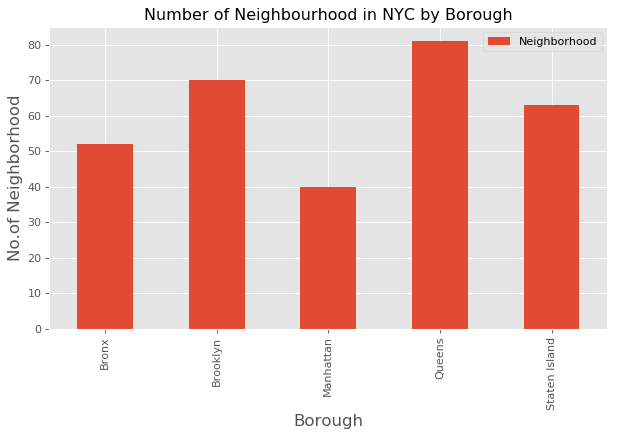

In [9]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [11]:
# prepare neighborhood list that contains italian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Resturants in Fordham, Bronx:9
( 18 / 306 ) Italian Resturants in East Tremont, Bronx:

( 141 / 306 ) Italian Resturants in Sunnyside, Queens:1
( 142 / 306 ) Italian Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Italian Resturants in Maspeth, Queens:2
( 144 / 306 ) Italian Resturants in Ridgewood, Queens:3
( 145 / 306 ) Italian Resturants in Glendale, Queens:1
( 146 / 306 ) Italian Resturants in Rego Park, Queens:1
( 147 / 306 ) Italian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Italian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Italian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Italian Resturants in College Point, Queens:1
( 151 / 306 ) Italian Resturants in Whitestone, Queens:4
( 152 / 306 ) Italian Resturants in Bayside, Queens:3
( 153 / 306 ) Italian Resturants in Auburndale, Queens:2
( 154 / 306 ) Italian Resturants in Little Neck, Queens:6
( 155 / 306 ) Italian Resturants in Douglaston, Queens:5
( 156 / 306 ) Italian Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Italian Resturants in Bellerose, Queens:2
( 158 / 306 ) Italian Resturants

( 276 / 306 ) Italian Resturants in Stuyvesant Town, Manhattan:3
( 277 / 306 ) Italian Resturants in Flatiron, Manhattan:3
( 278 / 306 ) Italian Resturants in Sunnyside Gardens, Queens:3
( 279 / 306 ) Italian Resturants in Blissville, Queens:0
( 280 / 306 ) Italian Resturants in Fulton Ferry, Brooklyn:2
( 281 / 306 ) Italian Resturants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Italian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Italian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Italian Resturants in Dumbo, Brooklyn:2
( 285 / 306 ) Italian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Italian Resturants in Willowbrook, Staten Island:1
( 287 / 306 ) Italian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Italian Resturants in Egbertville, Staten Island:1
( 289 / 306 ) Italian Resturants in Roxbury, Queens:0
( 290 / 306 ) Italian Resturants in Homecrest, Brooklyn:1
( 291 / 306 ) Italian Resturants in Middle Village, Queens:1
( 292 / 306 ) Itali

In [12]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [13]:
italian_rest_ny.shape

(540, 4)

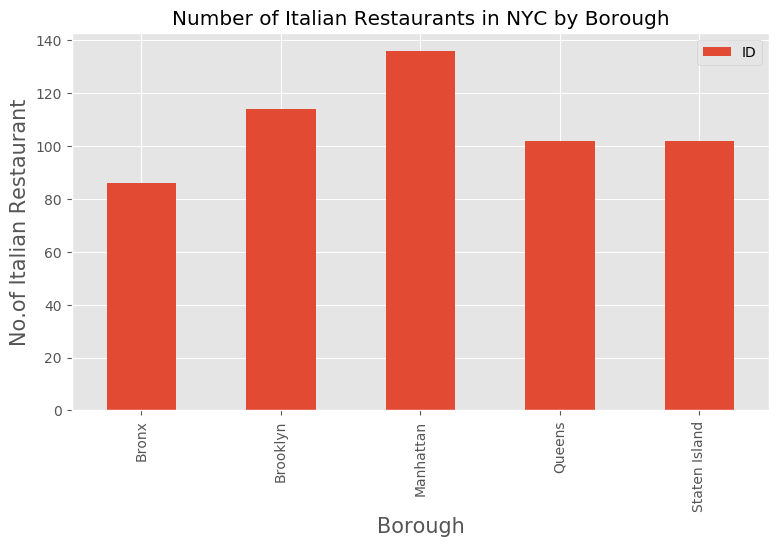

In [14]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurant', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

In [15]:
# Manhattan is Burough with most Italian Restaurants
manhat_italian=italian_rest_ny[italian_rest_ny['Borough']=='Manhattan']
manhat_italian

,Borough,Neighborhood,ID,Name
180,Manhattan,Chinatown,54f27deb498e47a670f5e399,Gelso & Grand
181,Manhattan,Washington Heights,4d21107c6e8c37042b58ff9f,Saggio Restaurant
182,Manhattan,Hamilton Heights,56d8e01d498ef1500ae7fbfe,Fumo
183,Manhattan,Hamilton Heights,558c6d42498eab8b9ee8da37,Bono Trattoria
184,Manhattan,Manhattanville,457f1183f964a5204b3f1fe3,Pisticci Ristorante
185,Manhattan,Manhattanville,4c956003f7cfa1cd2e2ebd15,Bettolona
186,Manhattan,Manhattanville,56d8e01d498ef1500ae7fbfe,Fumo
187,Manhattan,Manhattanville,3fd66200f964a52006e91ee3,Max SoHa
188,Manhattan,Manhattanville,5c0342b7f5e9d7002c22997a,Bar 314
189,Manhattan,Central Harlem,56d8e01d498ef1500ae7fbfe,Fumo


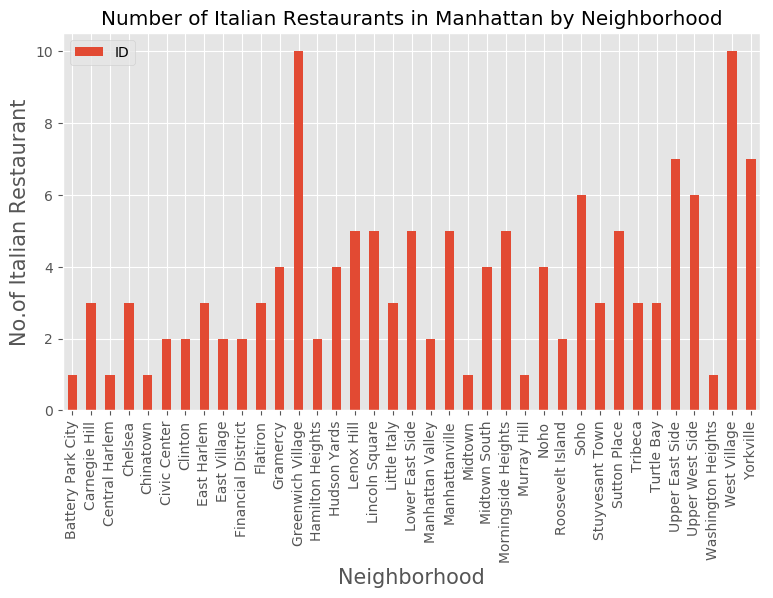

In [16]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants in Manhattan by Neighborhood')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurant', fontsize=15)
#giving a bar plot
manhat_italian.groupby('Neighborhood')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

West Village has most number of Italian Restaurants

In [17]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.7     4
( 1 / 540 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.7     4
( 2 / 540 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.4    14
( 3 / 540 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.3     8
( 4 / 540 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.4     6
( 5 / 540 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.1     8
( 6 / 540 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96a

No data available for id= 4bc22a22920eb713bcc51b2c
( 56 / 540 ) processed
No data available for id= 4c79d294278eb713f6a05580
( 57 / 540 ) processed
No data available for id= 4b5bc595f964a520431529e3
( 58 / 540 ) processed
No data available for id= 53ff939c498e6b601dfa3979
( 59 / 540 ) processed
No data available for id= 55aaee4d498e3cbb70e625d6
( 60 / 540 ) processed
No data available for id= 511b54f17ab47b5a3cc69aec
( 61 / 540 ) processed
No data available for id= 4b3bdd2cf964a520f57c25e3
( 62 / 540 ) processed
No data available for id= 4b451a29f964a520ad0426e3
( 63 / 540 ) processed
No data available for id= 4c9e1ef2542b224b70a3f09f
( 64 / 540 ) processed
No data available for id= 4b85b6b3f964a5209b6e31e3
( 65 / 540 ) processed
No data available for id= 4bc20b8d2a89ef3b6f1af388
( 66 / 540 ) processed
No data available for id= 4b634812f964a520936f2ae3
( 67 / 540 ) processed
No data available for id= 4b4e3e87f964a5209de626e3
( 68 / 540 ) processed
No data available for id= 4b491198f964

No data available for id= 4c2bbd1b2219c9288312a548
( 167 / 540 ) processed
No data available for id= 5698109e498eb4e676c57b75
( 168 / 540 ) processed
No data available for id= 58eac71c0319b80a65d5045b
( 169 / 540 ) processed
No data available for id= 4ffa2f57e4b05ae525579d36
( 170 / 540 ) processed
No data available for id= 4a358dfaf964a5202d9d1fe3
( 171 / 540 ) processed
No data available for id= 4dcabca41f6e2812677e3598
( 172 / 540 ) processed
No data available for id= 4106ec80f964a520890b1fe3
( 173 / 540 ) processed
No data available for id= 5cdf51a01f74400039a39cdf
( 174 / 540 ) processed
No data available for id= 4c0b017aa1b32d7f1d6d9af0
( 175 / 540 ) processed
No data available for id= 4c8455bfe602b1f7a28cae7a
( 176 / 540 ) processed
No data available for id= 525c26bc11d277827d14468f
( 177 / 540 ) processed
No data available for id= 55ff210c498ef9c10335dc0b
( 178 / 540 ) processed
No data available for id= 3fd66200f964a5205fee1ee3
( 179 / 540 ) processed
No data available for id=

No data available for id= 4c956003f7cfa1cd2e2ebd15
( 278 / 540 ) processed
No data available for id= 4b741ab4f964a5202cc82de3
( 279 / 540 ) processed
No data available for id= 57c772d1498e6cb2f6531cdf
( 280 / 540 ) processed
No data available for id= 3fd66200f964a520bce91ee3
( 281 / 540 ) processed
No data available for id= 5cc3adaa838e59002cb4629d
( 282 / 540 ) processed
No data available for id= 4b4f88adf964a5204c0a27e3
( 283 / 540 ) processed
No data available for id= 4a4560a7f964a5201aa81fe3
( 284 / 540 ) processed
No data available for id= 5078413372da7d9d2e0d54ca
( 285 / 540 ) processed
No data available for id= 5010b169e4b05edd9983ec7d
( 286 / 540 ) processed
No data available for id= 4a82d6adf964a5206ff91fe3
( 287 / 540 ) processed
No data available for id= 4bafdb5df964a52086263ce3
( 288 / 540 ) processed
No data available for id= 4bae3bd0f964a52009963be3
( 289 / 540 ) processed
No data available for id= 4e6409451495676d566f10b5
( 290 / 540 ) processed
No data available for id=

No data available for id= 4bc73ff96501c9b696063e29
( 388 / 540 ) processed
No data available for id= 4b9fb541f964a520fd3637e3
( 389 / 540 ) processed
No data available for id= 50dbec27e4b0cde37cd6b9be
( 390 / 540 ) processed
No data available for id= 4bd34792046076b02aaa7571
( 391 / 540 ) processed
No data available for id= 517dbe77e4b0eef580c875a3
( 392 / 540 ) processed
No data available for id= 5182ef83498e59069ff5e71b
( 393 / 540 ) processed
No data available for id= 4d4b4295ad4a6ea89135fbe9
( 394 / 540 ) processed
No data available for id= 4cb8efaa90c9a143a5e183d6
( 395 / 540 ) processed
No data available for id= 4c4a44f9bad7a593ee641daa
( 396 / 540 ) processed
No data available for id= 5182ef83498e59069ff5e71b
( 397 / 540 ) processed
No data available for id= 4faee0e2e4b08260e41249d3
( 398 / 540 ) processed
No data available for id= 4bf08bf117880f47a3782937
( 399 / 540 ) processed
No data available for id= 59fc9f85f193c02897fc2369
( 400 / 540 ) processed
No data available for id=

No data available for id= 4f74ff83e4b09b101271b89b
( 499 / 540 ) processed
No data available for id= 540a3547498e9b339b6431ae
( 500 / 540 ) processed
No data available for id= 59dfff99419a9e7fcc5b5fa2
( 501 / 540 ) processed
No data available for id= 5b1db44d0d8a0f002c17fd87
( 502 / 540 ) processed
No data available for id= 4a84b810f964a5206efd1fe3
( 503 / 540 ) processed
No data available for id= 589a66b251666a5ffadde9ea
( 504 / 540 ) processed
No data available for id= 40f1d480f964a520680a1fe3
( 505 / 540 ) processed
No data available for id= 49c6a988f964a5206e571fe3
( 506 / 540 ) processed
No data available for id= 5cc3adaa838e59002cb4629d
( 507 / 540 ) processed
No data available for id= 4b741ab4f964a5202cc82de3
( 508 / 540 ) processed
No data available for id= 4a8c84daf964a520530e20e3
( 509 / 540 ) processed
No data available for id= 555d29f7498eb6112f44ecac
( 510 / 540 ) processed
No data available for id= 4c0d4e92b1b676b07c63e086
( 511 / 540 ) processed
No data available for id=

NYC has 540 recorded Italian restaurants, but only 50 Bronx restaurants show full records.

In [18]:
italian_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.7,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.7,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.4,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.3,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6
5,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden,26,7.1,8
6,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.6,11
7,Bronx,Pelham Parkway,4b10591af964a5205f6e23e3,Patricia's,84,8.5,39
8,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,9,6.5,8
9,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood,44,8.4,27


Looks like Foursquare does not have data for restaurants previously listed. The reason behind this could potentially be attributed to the economic impact of the COVID-19 pandemic. Further research must be done. For the scope of this course, I will continue on with this analysis.

In [19]:
italian_rest_stats_ny.shape

(540, 7)

In [20]:
italian_rest_ny.shape

(540, 4)

In [21]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

In [22]:
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [23]:
italian_rest_stats_ny_csv.shape

(540, 7)

In [24]:
italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.7,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.7,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.4,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.3,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6


In [25]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
Borough         540 non-null object
Neighborhood    540 non-null object
ID              540 non-null object
Name            540 non-null object
Likes           540 non-null object
Rating          540 non-null float64
Tips            540 non-null object
dtypes: float64(1), object(6)
memory usage: 29.6+ KB


In [26]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [27]:
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [28]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
Borough         540 non-null object
Neighborhood    540 non-null object
ID              540 non-null object
Name            540 non-null object
Likes           540 non-null float64
Rating          540 non-null float64
Tips            540 non-null float64
dtypes: float64(3), object(4)
memory usage: 29.6+ KB


In [29]:
# Restaurant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                177
Rating                               8.5
Tips                                  72
Name: 38, dtype: object

In [30]:
# Restaurant with maximum Rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.3
Tips                                  48
Name: 13, dtype: object

In [31]:
# Restaurant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                177
Rating                               8.5
Tips                                  72
Name: 38, dtype: object

In [32]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [33]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
116,Morrisania,8.300000
63,Fordham,8.255556
176,Van Nest,8.100000
134,Pelham Parkway,7.866667
9,Baychester,7.750000
115,Morris Park,7.620000
11,Bedford Park,7.600000
109,Melrose,7.550000
32,City Island,7.533333
187,Woodlawn,7.350000


In [34]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [35]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,4.311628
1,Brooklyn,0.000000
2,Manhattan,0.000000
3,Queens,0.000000
4,Staten Island,0.000000


Here we see that not enough/no data is available for italian restaurants outside of the Bronx.

In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [37]:
ny_neighborhood_stats

,Neighborhood,Average Rating
9,Baychester,7.750000
11,Bedford Park,7.600000
32,City Island,7.533333
63,Fordham,8.255556
109,Melrose,7.550000
115,Morris Park,7.620000
116,Morrisania,8.300000
134,Pelham Parkway,7.866667
167,Throgs Neck,7.050000
176,Van Nest,8.100000


In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [40]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
6,Bronx,Morrisania,40.823592,-73.901506,8.300000
3,Bronx,Fordham,40.860997,-73.896427,8.255556
9,Bronx,Van Nest,40.843608,-73.866299,8.100000
7,Bronx,Pelham Parkway,40.857413,-73.854756,7.866667
0,Bronx,Baychester,40.866858,-73.835798,7.750000


In [41]:
# create map and display
ny_map = folium.Map(location=(40.8448, -73.8648), zoom_start=12)

In [42]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

1. Best places to open an Italian restaurant Morrisania, Fordham, and Van Nest
2. Because of the lack of Foursquare data, the Bronx has the most up to date and detailed information on its restaurants.
3. For financial security's sake, I recommend testing out the market in Fordham in the Bronx because of the low cost of rent and relative safety compared to other neighborhoods (rated third in terms of safety).
4. Additionally, the ratings of Italian restaurants in Fordham are the second highest in the Bronx (8.25/10).
